# Save Pluto!

Run the cell below to set up everything we'll need

In [343]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('paper')
%matplotlib inline

class Clicker(object):
    def __init__(self,j,k,m,e, Npts=300):
        fig, self.ax = plt.subplots(figsize=(12,8))
        self.j = j
        self.k = k
        self.m = m
        ecross = 1 - ((j-k)/j)**(2/3)
        self.etilde = e/ecross
        self.Npts = Npts
        self.cid = self.ax.figure.canvas.mpl_connect('button_press_event', self)
        
        if k > 5:
            raise("Only supports resonances of order k=5 or less")
        h = [0, 0.535, 0.426, 0.420, 0.454, 0.519] # coefficients for k order resonances
        self.ax.set_xlim([0,2*np.pi])
        #fracPwidth = 2*np.sqrt(3*h[k])*m**(1/2)*etilde**(k/2)
        #self.ax.set_ylim([j/(j-k)-10*Pwidth, j/(j-k)+10*Pwidth])
        self.ax.set_xlabel('Res. Angle $\phi$',fontsize=18)
        self.ax.set_ylabel('Period Ratio',fontsize=18)
        
    def __call__(self, event):
        phi = event.xdata
        P = event.ydata
        
        sim = self.make_sim(phi, P, self.m, self.etilde, self.j, self.k)
        philist, Plist, collision = self.run(sim, self.j, self.k)
        if collision == True:
            if phi:
                self.ax.plot(philist, Plist, 'r.')
            else:
                self.ax.plot([phi], [P], 'r.') # plot initial point in case collision happens before first crossing
        else:
            self.ax.plot(philist, Plist, 'k.')
    
    def make_sim(self, phi, P, m, etilde, j, k):
        ecross = 1 - ((j-k)/j)**(2/3)
        e = self.etilde*ecross
        
        # start l1 at pi 
        # phi = j*l2 - (j-k)*l1 - k*pomega1
        # if pomega1 = 0, l1=pi, l2 = (phi+(j-k)*pi)/j
        sim = rebound.Simulation()
        sim.add(m=1)
        sim.add(m=m, P=1, l=(phi-j*np.pi)/k)
        sim.add(e=e, P=P, l=sim.particles[1].l + np.pi)
        sim.move_to_com()
        sim.particles[1].r = sim.particles[1].a*(sim.particles[1].m/3/sim.particles[0].m)**(1/3)
        sim.collision = "line"
        return sim

    def hyper(self, sim): # section when l1 overtakes l2. When l1 < l2, sin(l2-l1) > 0, when it overtakes, sin(l2-l1)<0
        return np.sin(sim.particles[2].l-sim.particles[1].l) 

    def run(self, sim, j, k):
        N_points_max = self.Npts # maximum number of point in our Poincare Section
        N_points = 0
        poincare_map = np.zeros((N_points_max,2))
        ps = sim.particles
        
        # Integrate simulation in small intervals
        # After each interval check if we crossed the 
        # hypersurface. If so, bisect until we hit the 
        # hypersurface exactly up to a precision
        # of dt_epsilon
        dt = 0.1
        dt_epsilon = 1e-2*dt
        sign = self.hyper(sim)
        phi, P = [], []
        collision=False
        while sim.t<1e4 and N_points < N_points_max:
            oldt = sim.t
            olddt = sim.dt
            try:
                sim.integrate(oldt+dt)
            except rebound.Collision:
                collision=True
                return phi, P, collision
            nsign = self.hyper(sim)
            if sign > 0 and nsign < 0.: # see condition in hyper
                # Hyper surface crossed.
                leftt = oldt
                rightt = sim.t
                sim.dt = -olddt
                while (rightt-leftt > dt_epsilon):
                    # Bisection.
                    midt = (leftt+rightt)/2.
                    try:
                        sim.integrate(midt)
                    except:
                        collision=True
                        return phi, P, collision
                    
                    msign = self.hyper(sim)
                    if msign*sign > 0.:
                        leftt = midt
                        sim.dt = 0.3*olddt
                    else:
                        rightt = midt
                        sim.dt = -0.3*olddt
                # Hyper surface found up to precision of dt_epsilon. Store phi and P
                # Don't need to check crossing direction, since l1 always overtakes l2. But need to check (l2-l1) != pi
                if np.cos(ps[2].l-ps[1].l) > 0: 
                    tp = np.pi*2.
                    phi.append(np.mod(j*ps[2].l-(j-k)*ps[1].l-k*ps[2].pomega, 2*np.pi))
                    P.append(ps[2].P/ps[1].P) # Store value for map
                    N_points += 1
                sim.dt = olddt
                try:
                    sim.integrate(oldt+dt)
                except:
                    collision=True
                    return phi, P, collision
            sign = nsign
        return phi, P, collision

# A) Finding a Stable Configuration

Here we're giving Pluto an orbital period that is exactly 3/2 longer than that of Neptune. But if we numerically integrate the system, the period ratio does not stay at 1.5. 

1) How close can you get the the system to stay to a period ratio of 1.5 by varying lambda_Nep and lambda_Pluto (first two lines of the cell below, measured in radians)? This would be a configuration that perfectly repeats. (press shift+enter to run the cell after you choose the lambdas)

2) Can you find a range of angles that send Pluto into a very different orbit? 

3) For a given choice of lambdas, at which point in the cycle will planets interact most strongly?

4) What's special about the stable, repeating configuration? 

Text(0.5, 1.0, 'Initial Configuration')

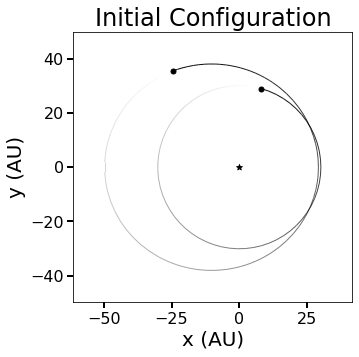

In [271]:
lambda_Nep = 1.3
lambda_Pluto = 1.7
P_Nep = 165
P_Pluto = 165*3/2

sim = rebound.Simulation()
sim.units = ['AU', 'yr', 'Msun']
sim.add(m=1)
sim.add(m=5.15e-05, P=P_Nep, e=0, l=lambda_Nep)
sim.add(m=0, P=P_Pluto, e=0.26, l=lambda_Pluto)
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 0.03*ps[1].P
#sim.particles[1].r = sim.particles[1].a*(sim.particles[1].m/3/sim.particles[0].m)**(1/3)
sim.collision = "line"
        
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
ax.set_title('Initial Configuration')

Text(0, 0.5, 'Period Ratio')

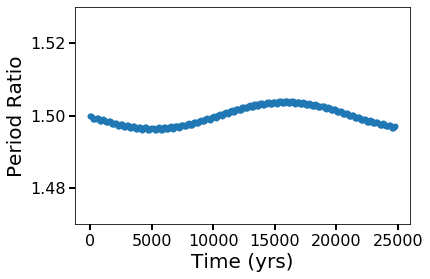

In [272]:
ps = sim.particles
Nout = 300
times = np.linspace(0, 100*ps[2].P, Nout)
Pratio = np.zeros(Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    Pratio[i] = ps[2].P/ps[1].P
    
fig, ax = plt.subplots()
ax.plot(times, Pratio, '.')
ax.set_ylim([min(1.47, Pratio.min()), max(1.53, Pratio.max())])
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Period Ratio')

# B) Crisis!

1) Calculate for a period ratio of 1.55, and initial phi = 4.22, how long it should take for phi to reach zero

Bonus) Vary tmax to see how long until Pluto is ejected from the solar system

<IPython.core.display.Javascript object>


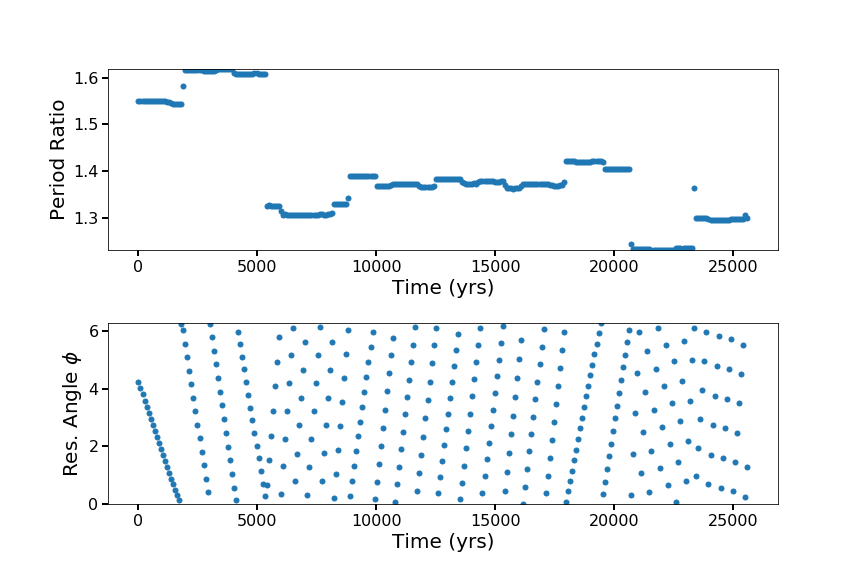

In [336]:
phi = 4.22
Pratio = 1.55

tmax = 100 # how many orbits of Pluto to integrate

P_Nep = 165
P_Pluto = 165*Pratio
pomega_Pluto = 3.94
sim = rebound.Simulation()
sim.units = ['AU', 'yr', 'Msun']
sim.add(m=1)
sim.add(m=5.15e-05, P=P_Nep, e=0, l=pomega_Pluto+phi)
sim.add(m=0, P=P_Pluto, e=0.26, pomega=pomega_Pluto, l=pomega_Pluto+phi)
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 0.03*ps[1].P

ps = sim.particles
Nout = 300
times = np.linspace(0, tmax*ps[2].P, Nout)
phi = np.zeros(Nout)
Pratio = np.zeros(Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    phi[i] = np.mod(3*ps[2].l - 2*ps[1].l - ps[2].pomega, 2*np.pi)
    Pratio[i] = ps[2].P/ps[1].P
    
fig, axarr = plt.subplots(figsize=(12,8), nrows=2)
ax = axarr[0]
ax.plot(times, Pratio, '.')
ax.set_ylim([min(1.47, Pratio.min()), max(1.53, Pratio.max())])
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Period Ratio')

ax = axarr[1]
ax.plot(times, phi, '.')
ax.set_ylim([0, 2*np.pi])
ax.set_xlabel('Time (yrs)')
ax.set_ylabel(r'Res. Angle $\phi$')
fig.subplots_adjust(hspace=0.4)

Check what the system looks like at the end of the integration

<IPython.core.display.Javascript object>


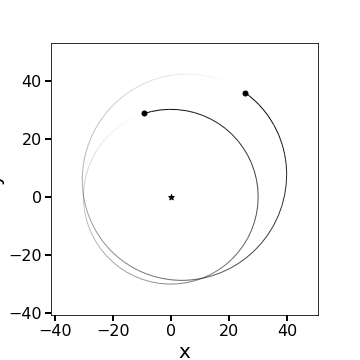

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff869fad110>)

In [337]:
rebound.OrbitPlot(sim)

# C) What Does Pluto Actually Do?

Neptune's period is about 165 years, and isn't affected almost at all by Pluto since Neptune is about 10,000 times more massive. So when we see the period ratio changing, we're really seeing the orbital period of Pluto changing.

1) What's the period for the oscillation of Pluto's orbital period?

2) By how many years does Pluto's orbital period change over one of these cycles?

<IPython.core.display.Javascript object>


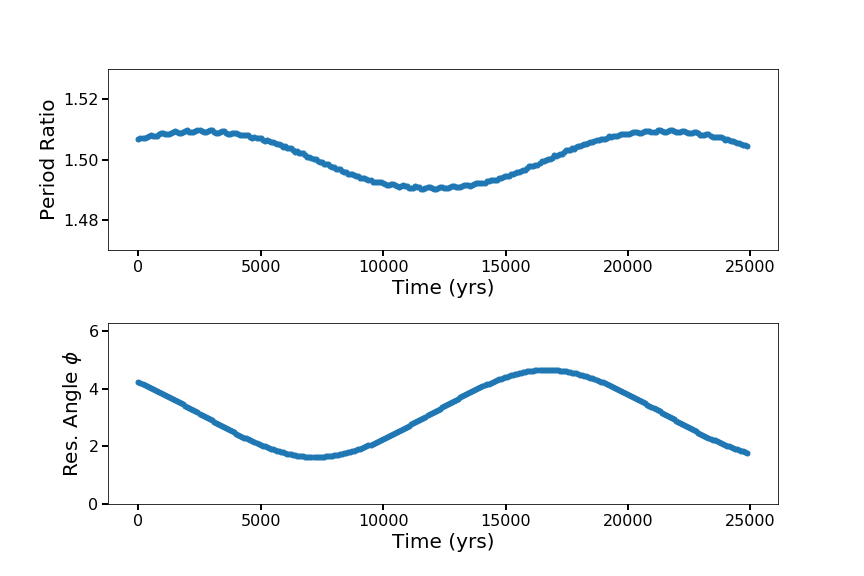

In [338]:
phi = 4.22
Pratio = 1.507

tmax = 100 # how many orbits of Pluto to integrate

P_Nep = 165
P_Pluto = 165*Pratio
pomega_Pluto = 3.94
sim = rebound.Simulation()
sim.units = ['AU', 'yr', 'Msun']
sim.add(m=1)
sim.add(m=5.15e-05, P=P_Nep, e=0, l=pomega_Pluto+phi)
sim.add(m=0, P=P_Pluto, e=0.26, pomega=pomega_Pluto, l=pomega_Pluto+phi)
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 0.03*ps[1].P

ps = sim.particles
Nout = 300
times = np.linspace(0, tmax*ps[2].P, Nout)
phi = np.zeros(Nout)
Pratio = np.zeros(Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    phi[i] = np.mod(3*ps[2].l - 2*ps[1].l - ps[2].pomega, 2*np.pi)
    Pratio[i] = ps[2].P/ps[1].P
    
fig, axarr = plt.subplots(figsize=(12,8), nrows=2)
ax = axarr[0]
ax.plot(times, Pratio, '.')
ax.set_ylim([min(1.47, Pratio.min()), max(1.53, Pratio.max())])
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Period Ratio')

ax = axarr[1]
ax.plot(times, phi, '.')
ax.set_ylim([0, 2*np.pi])
ax.set_xlabel('Time (yrs)')
ax.set_ylabel(r'Res. Angle $\phi$')
fig.subplots_adjust(hspace=0.4)

# D) Moving To Phase Space

1) Click on the plot below (approximately) at Pluto's current period ratio of 1.507 and phi=4.22. Check that you get variations in the period ratio and phi that match what you got above

2) Check the unstable case you calculated above (at a period ratio of 1.55 and phi=4.22). Red dots mean that Pluto collided with Neptune or got ejected from the Solar System.

3) Click other places to fill in the space

4) What's approximately the maximum range of period ratios that are protected by the resonance? This is the width of the resonance.

<IPython.core.display.Javascript object>


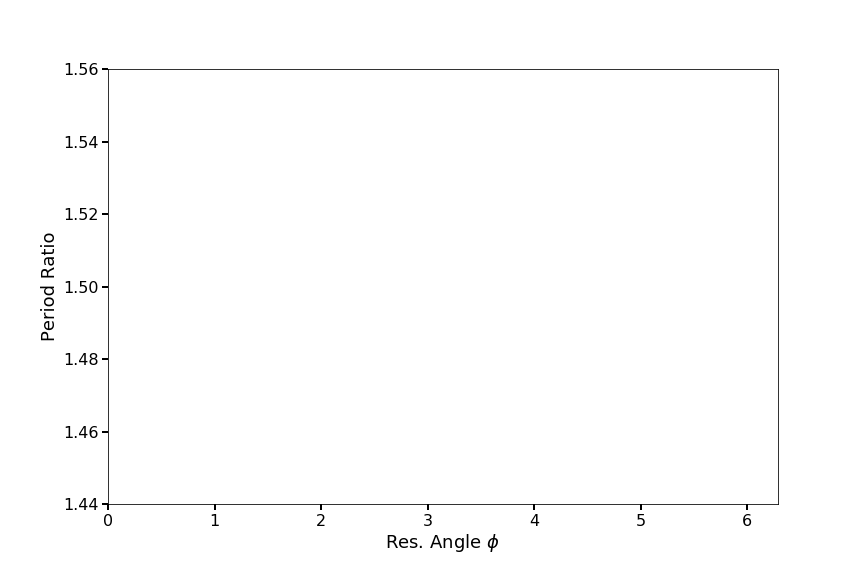

(0, 6.283185307179586)

In [347]:
%matplotlib notebook

clicker=Clicker(j=3, k=1, m=5e-5, e=0.26) 
clicker.ax.set_ylim([1.44, 1.56])
clicker.ax.set_xlim([0, 2*np.pi])